[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/tutorials/adaptive_substepping/adaptive_substepping.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/tutorials/adaptive_substepping/adaptive_substepping.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/tutorials/adaptive_substepping/adaptive_substepping.ipynb)

In [1]:
import os, sys
os.environ['NUMBA_THREADING_LAYER'] = 'workqueue'  # PySDM & PyMPDATA don't work with TBB; OpenMP has extra dependencies on macOS
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples', 'PySDM')

In [2]:
from functools import partial
import math
import timeit
import numpy as np, scipy
from scipy.optimize import elementwise
from matplotlib import pyplot
from collections import namedtuple, defaultdict
from matplotlib.gridspec import GridSpec

# import os
# os.environ['NUMBA_DISABLE_JIT']='1'

import numba

from open_atmos_jupyter_utils import show_plot
from PySDM import physics
from PySDM_examples.Grabowski_and_Pawlowska_2023.settings import DRY_SPECTRA
from PySDM.initialisation.sampling.spectral_sampling import ConstantMultiplicity
from PySDM.physics.dimensional_analysis import DimensionalAnalysis
from PySDM.backends.impl_numba.toms748 import toms748_solve
from PySDM.backends.impl_numba.warnings import warn


# import warnings
# warnings.filterwarnings("error")

In [3]:
N_SD = 2**3  # TEMP 2**10
commons = {
    "kappa": 1.28,
    "init_temperature_K": 300,
    "init_dry_pressure_Pa": 100000,
    "total_water_mixing_ratio": 21.5 / 1000,
    "t_max_s": 300,  # TEMP!
}
make_namedtuple = lambda name, items: namedtuple(name, items.keys())(*items.values())

In [4]:
formulae = make_namedtuple(
    "F",
    {
        # eq. (1) in the NPG paper
        "drw_dt": lambda c, rw, rho_v, rho_o: c.D_eff / c.rho_w * (rho_v - rho_o) / rw,
        # eq. (4) in the NPG paper
        "RH_eq": lambda c, rw, rd: 1 + c.A / rw - c.κ * (rd / rw) ** 3,
        # eq. (13) in the NPG paper
        "dpd_dt": lambda c, rhod, w: -rhod * c.g * w,
        "dT_dt": lambda c, dpd_dt, dqv_dt, rhod: (dpd_dt / rhod - dqv_dt * c.l_v)
        / c.cp_d,
        "dthd_dt": lambda c, T, thd, rhod, dqv_dt: -c.l_v * dqv_dt / c.cp_d / T * thd,
        # Bolton 1980 saturation vapour pressure formula (https://doi.org/10.1175/1520-0493(1980)108%3C1046:TCOEPT%3E2.0.CO;2)
        "pvs": lambda c, T: c.B80_G0
        * np.exp((c.B80_G1 * (T - c.T0)) / ((T - c.T0) + c.B80_G2)),
        # trivia
        "rhod": lambda c, pd, T: pd / c.R_d / T,
        "rhov": lambda c, pv, T: pv / c.R_v / T,
        "thd": lambda c, T, pd: T * np.power(c.p1000 / pd, c.R_d / c.cp_d),
        "T": lambda c, θd, ρd: θd
        * (ρd * θd / c.p1000 * c.R_d) ** (c.R_d / c.cp_d / (1 - c.R_d / c.cp_d)),
        "pd": lambda c, T, ρd: c.R_d * T * ρd,
        "pv": lambda c, qt, T, rhod: qt * c.R_v * T * rhod,
        "RH": lambda c, ml, rho_vs, rhod: rhod * (c.qt - ml / c.m_d) / rho_vs,
        "dqv_dt": lambda c, rw, drw_dt: -4
        * np.pi
        * np.dot(c.xi * rw**2, drw_dt)
        / c.m_d
        * c.rho_w,
        "w": lambda c, t: c.w_mean
        * np.pi
        / 2
        * np.sin(np.pi * t * c.w_mean / c.z_half),
        "z": lambda c, t: c.z_half / 2 * (1 - np.cos(np.pi * t * c.w_mean / c.z_half)),
        "r_c": lambda c, rd: (3 * c.κ * rd**3 / c.A) ** 0.5,
        "ml": lambda c, rw, xi: (xi @ rw**3) * 4 / 3 * np.pi * c.rho_w,
        "ml_scalar": lambda c, rw, xi: rw**3 * xi * 4 / 3 * np.pi * c.rho_w,
        # size variable:
        "rw": lambda c, x: c.r0 * np.exp(x),
        "x": lambda c, rw: np.log(rw / c.r0),
        "drw_dx": lambda rw: rw,
    },
)

In [5]:
def constants(*, n_sd, aerosol, total_water_mixing_ratio, t_max_s, w_multiplier, kappa):
    r_dry, multiplicities = ConstantMultiplicity(
        DRY_SPECTRA[aerosol][kappa]
    ).sample_deterministic(n_sd)
    ix = make_namedtuple(
        "I", {"x": slice(0, n_sd), "pd": n_sd, "T": n_sd + 1, "size": n_sd + 2}
    )

    SI = physics.si
    M_a = 0.029 * SI.kg / SI.mole
    M_v = 0.018 * SI.kg / SI.mole
    R_str = scipy.constants.R * SI.J / SI.K / SI.mole

    constants = make_namedtuple(
        "C",
        {
            "R_d": R_str / M_a,
            "R_v": R_str / M_v,
            "cp_d": 1000 * SI.J / SI.kg / SI.K,
            "l_v": 45000 * SI.joule / SI.mol / M_v,
            "g": scipy.constants.g * SI.m / SI.s**2,
            "A": 1e-3 * SI.um,
            "rho_w": 1 * SI.kg / SI.litre,
            "D_eff": 2.3e-5 * SI.metre**2 / SI.s,
            "T0": scipy.constants.zero_Celsius * SI.K,
            "p1000": 1000 * SI.hPa,
            "B80_G0": 6.112 * SI.hPa,
            "B80_G1": 17.67 * SI.dimensionless,
            "B80_G2": 243.5 * SI.K,
            "r0": SI.nm,
            "κ": kappa,
            "rd": r_dry * SI.m,
            "xi": multiplicities,
            "m_d": 1 * SI.kg,
            "qt": total_water_mixing_ratio,
            "t_max": t_max_s * SI.s,
            "w_mean": w_multiplier * SI.m / SI.s,
            "z_half": 150 * SI.m,  # TEMP
            "ix": ix,
        },
    )
    return constants, SI

def initial_condition(
    SI,
    c,
    init_dry_pressure_Pa,
    init_temperature_K,
):
    rh = formulae.RH(
        c,
        ml=0,
        rho_vs=formulae.rhov(
            c, pv=formulae.pvs(c, init_temperature_K), T=init_temperature_K
        ),
        rhod=formulae.rhod(c, pd=init_dry_pressure_Pa, T=init_temperature_K),
    )
    result = elementwise.find_root(
        lambda rw, rd: rh - formulae.RH_eq(c, rw, rd),
        (c.rd, formulae.r_c(c, c.rd)),
        args=(c.rd,),
    )
    assert all(result.success)

    y0 = [0] * c.ix.size
    y0[c.ix.pd] = init_dry_pressure_Pa * SI.Pa
    y0[c.ix.T] = init_temperature_K * SI.K
    y0[c.ix.x] = formulae.x(c, rw=result.x)
    return y0

In [6]:
jit_compile = numba.jit(error_model="numpy", fastmath=True)
jf = make_namedtuple("J", {k: jit_compile(v) for k, v in formulae._asdict().items()})

@jit_compile
def ode_rhs(t, y, c):
    rhod = jf.rhod(c, pd=y[c.ix.pd], T=y[c.ix.T])
    rho_vs = jf.rhov(c, pv=jf.pvs(c, y[c.ix.T]), T=y[c.ix.T])
    rw = jf.rw(c, x=y[c.ix.x])  # TODO: we do not need to allocate this!

    dy_dt = np.empty_like(y)
    dy_dt[c.ix.pd] = jf.dpd_dt(c, rhod=rhod, w=jf.w(c, t))
    dy_dt[c.ix.x] = jf.drw_dt(
        c,
        rw=rw,
        rho_v=jf.RH(c, ml=jf.ml(c, rw=rw, xi=c.xi), rho_vs=rho_vs, rhod=rhod) * rho_vs,
        rho_o=jf.RH_eq(c, rw=rw, rd=c.rd) * rho_vs,
    ) / jf.drw_dx(rw)
    dy_dt[c.ix.T] = jf.dT_dt(
        c,
        dpd_dt=dy_dt[c.ix.pd],
        dqv_dt=jf.dqv_dt(c, rw=rw, drw_dt=dy_dt[c.ix.x] * jf.drw_dx(rw)),
        rhod=rhod,
    )
    return dy_dt

In [7]:
# Bartman et al. adaptivity algorithm:
# - does not require additional state-vector-size memory
# - implicit-in-size/explicit-in-thermodynamics

@jit_compile
def adapt_substeps(
    step_impl_args,
    dt,
    n_substeps,
    rh,
    thd,
    rtol,
    min_step,
    max_step,
    multiplier=2,
    fuse=32,
): # pylint: disable=too-many-positional-arguments
    """calls `calculate_ml_new(fake=True) ..."""
    n_substeps_max = math.floor(dt / min_step)
    n_substeps_min = math.ceil(dt / max_step)
    n_substeps = np.maximum(n_substeps_min, n_substeps // multiplier)
    success = False
    rh_new_long, thd_new_long = np.nan, np.nan
    for burnout in range(fuse + 1):
        if burnout == fuse:
            return warn("burnout (long)", __name__, return_value=(0, False))
        _, thd_new_long, rh_new_long, success = step(
            *step_impl_args, dt / n_substeps, 1, True, rtol
        )
        if success:
            break
        n_substeps *= multiplier
    for burnout in range(fuse + 1):
        if burnout == fuse:
            return warn("burnout (short)", __name__, return_value=(0, False))
        _, thd_new_short, rh_new_short, success = step(
            *step_impl_args, dt / (n_substeps * multiplier), 1, True, rtol
        )
        if not success:
            return warn("short failed", __name__, return_value=(0, False))
        if rtol.name == "rh":
            est = np.abs(rh_new_long - rh - multiplier * (rh_new_short - rh))
            rh_new_long = rh_new_short
            if within_tol(est, rh, rtol.rh):
                break
        elif rtol.name == "thd":
            est = np.abs(thd_new_long - thd - multiplier * (thd_new_short - thd))
            thd_new_long = thd_new_short
            if within_tol(est, thd, rtol.thd):
                break
        n_substeps *= multiplier
        if n_substeps > n_substeps_max:
            break
    return np.minimum(n_substeps_max, n_substeps), success

@jit_compile
def minfun(x_new, c, ρv, rd, ρvs, x_old, dt):
    return (
        x_old
        - x_new
        + dt
        * jf.drw_dt(
            c,
            rw=jf.rw(c, x=x_new),
            rho_v=ρv,
            rho_o=jf.RH_eq(c, rw=jf.rw(c, x=x_new), rd=rd) * ρvs,
        )
        / jf.drw_dx(rw=jf.rw(c, x=x_new))
    )

@jit_compile
def within_tol(error_estimate, value, rtol):
    return error_estimate < rtol * np.abs(value)

@jit_compile
def calculate_ml_new(c, x_old, x_new, dt, fake, ρv, ρvs, rtol): # pylint: disable=too-many-positional-arguments
    """implicit Euler solution for drop sizes altering the
    `x` argument if `fake` if False, otherwise returning the
    new liquid water mass without changing `x`"""
    max_iters = 16
    ml_new = 0
    success = True
    for drop in range(len(c.rd)):
        x_insane = jf.x(c, rw=c.rd[drop] / 100**1 / 3)
        args = c, ρv, c.rd[drop], ρvs, x_old[drop], dt

        RH = ρv / ρvs
        RH_eq = jf.RH_eq(c, rw=jf.rw(c, x=x_old[drop]), rd=c.rd[drop])
        if not within_tol(np.abs(RH - RH_eq), RH, rtol.rh_eq):
            dx_old = minfun(x_old[drop], *args)
        else:
            dx_old = 0
        if dx_old == 0:
            x_root = x_old[drop]
        else:
            a, b = x_old[drop], max(x_insane, x_old[drop] + dx_old)
            fa, fb = minfun(a, *args), minfun(b, *args)
            counter = 0
            while not fa * fb < 0:
                counter += 1
                if counter > max_iters:
                    if not fake:
                        warn(
                            "failed to find interval",
                            __name__,
                            context=("a", a, "b", b, "fa", fa, "fb", fb),
                        )
                    success = False
                    break
                b = max(x_insane, a + math.ldexp(dx_old, counter))
                fb = minfun(b, *args)
            if not success:
                break
            if a != b:
                if a > b:
                    a, b = b, a
                    fa, fb = fb, fa
                x_root, iters_taken = toms748_solve(
                    minfun,
                    args,
                    a,
                    b,
                    fa,
                    fb,
                    rtol=rtol.x,
                    max_iter=max_iters,
                    within_tolerance=within_tol,
                )
                if iters_taken in (-1, max_iters):
                    if not fake:
                        warn("TOMS failed", __name__)
                    success = False
                    break
            else:
                x_root = x_old[drop]

        ml_new += jf.ml_scalar(c, rw=jf.rw(c, x=x_root), xi=c.xi[drop])
        if not fake:
            x_new[drop] = x_root
    return ml_new, success

@jit_compile
def step(
    c, x_old, x_new, qv, dqv_dt, θd, dθd_dt, ρd, dρd_dt, dt, n_substeps, fake, rtol
): # pylint: disable=too-many-positional-arguments
    """explicit (trapezoidal) integration of thermodynamics coupled
    with external implicit solver for drop sizes"""
    dt /= n_substeps
    ml_old = jf.ml(c, rw=jf.rw(c, x=x_old), xi=c.xi)
    success = True
    assert n_substeps == 1 or not fake
    for _ in range(n_substeps):
        θd += dt * dθd_dt / 2
        qv += dt * dqv_dt / 2
        ρd += dt * dρd_dt / 2

        T = jf.T(c, θd=θd, ρd=ρd)
        ρvs_new = jf.rhov(c, pv=jf.pvs(c, T=T), T=T)
        ρv_new = jf.RH(c, ml=ml_old, rho_vs=ρvs_new, rhod=ρd) * ρvs_new
        ml_new, success_within_substep = calculate_ml_new(
            c, x_old, x_new, dt, fake, ρv_new, ρvs_new, rtol
        )
        dml_dt = (ml_new - ml_old) / dt

        dqv_dt_cond = -dml_dt / c.m_d
        dθd_dt_cond = jf.dthd_dt(c, T=T, thd=θd, rhod=ρd, dqv_dt=dqv_dt_cond)
        θd += dt * (dθd_dt / 2 + dθd_dt_cond)
        qv += dt * (dqv_dt / 2 + dqv_dt_cond)
        ρd += dt * dρd_dt / 2
        ml_old = ml_new
        if not fake:
            x_old[:] = x_new[:]
        success = success and success_within_substep
    T = jf.T(c, θd=θd, ρd=ρd)
    ρvs_new = jf.rhov(c, pv=jf.pvs(c, T=T), T=T)
    return qv, θd, jf.RH(c, ml=ml_old, rho_vs=ρvs_new, rhod=ρd), success


@jit_compile
def qθρ_rh(c, pd, T, rw):
    ρd = jf.rhod(c, pd=pd, T=T)
    pvs = jf.pvs(c, T)
    RH = jf.RH(c, ml=jf.ml(c, rw=rw, xi=c.xi), rho_vs=jf.rhov(c, pv=pvs, T=T), rhod=ρd)
    return (
        jf.rhov(c, pv=RH * pvs, T=T) / ρd,
        jf.thd(c, T=T, pd=pd),
        ρd,
        RH,
    )

@jit_compile
def stepper(y, t_eval, c, adaptive, rtol, min_step, max_step, dt_adaptive, n_substeps): # pylint: disable=too-many-positional-arguments
    success = True

    for i in range(1, len(t_eval)):
        pd_old = y[c.ix.pd, i - 1]
        T_old = y[c.ix.T, i - 1]
        rw_old = jf.rw(c, x=y[c.ix.x, i - 1])
        qv_old, θd_old, ρd_old, _ = qθρ_rh(c, pd_old, T_old, rw_old)

        dt = t_eval[i] - t_eval[i - 1]
        dpd_dt_old = jf.dpd_dt(c, rhod=ρd_old, w=jf.w(c, t_eval[i - 1] + dt / 2))
        dT_dt_old = jf.dT_dt(c, dpd_dt=dpd_dt_old, dqv_dt=0, rhod=ρd_old)

        pd_new = pd_old + dt * dpd_dt_old
        T_new = T_old + dt * dT_dt_old

        qv_new, θd_new, ρd_new, rh_new = qθρ_rh(c, pd_new, T_new, rw_old)

        step_args = (
            c,
            y[c.ix.x, i - 1],
            y[c.ix.x, i],
            qv_old,
            (qv_new - qv_old) / dt,
            θd_old,
            (θd_new - θd_old) / dt,
            ρd_old,
            (ρd_new - ρd_old) / dt,
        )
        if adaptive:
            n_substeps, success = adapt_substeps(
                step_args,
                dt,
                n_substeps,
                rh_new,
                θd_new,
                rtol,
                min_step,
                min(dt, max_step),
            )
            dt_adaptive[i - 1] = dt / n_substeps
        if success:
            qv_new, θd_new, _, success = step(*step_args, dt, n_substeps, False, rtol)
        else:
            qv_new, θd_new = np.nan, np.nan

        y[c.ix.T, i] = jf.T(c, θd=θd_new, ρd=ρd_new)
        y[c.ix.pd, i] = jf.pd(c, T=y[c.ix.T, i], ρd=ρd_new)

    return success


def adaptive_solver(*, t_eval, y0, min_step, max_step, args, adaptive, n_substeps, rtol):
    y = np.empty(shape=(len(y0), len(t_eval)))
    dt_adaptive = np.empty(shape=(len(t_eval) - 1,))
    y[:, 0] = y0
    success = stepper(
        y, t_eval, args[0], adaptive, rtol, min_step, max_step, dt_adaptive, n_substeps
    )
    return make_namedtuple(
        "AS",
        {
            "success": success,
            "message": __name__,
            "y": y,
            "t": t_eval,
            "dt_adaptive": dt_adaptive if adaptive else None,
        },
    )

In [8]:
def run(n_sd, rtol=None, w_multiplier=np.nan, lsoda_eps=None, plot_spectrum=False, non_adaptive_substeps=1):
    solutions = {}
    times = {}
    c, SI, y0 = None, None, None
    for aerosol in DRY_SPECTRA:
        solutions[aerosol] = {}
        times[aerosol] = {}
        c, SI = constants(
            n_sd=n_sd,
            aerosol=aerosol,
            w_multiplier=w_multiplier,
            total_water_mixing_ratio=commons["total_water_mixing_ratio"],
            t_max_s=commons["t_max_s"],
            kappa=commons["kappa"],
        )
        if plot_spectrum:
            pyplot.hist(
                np.log(c.rd), weights=c.xi, density=False, label=aerosol, alpha=0.5
            )
        else:
            y0 = initial_condition(
                SI,
                c=c,
                init_dry_pressure_Pa=commons["init_dry_pressure_Pa"],
                init_temperature_K=commons["init_temperature_K"],
            )
            nt = 255
            t_end = c.t_max / w_multiplier
            for key, solver in {
                "non-adaptive": partial(
                    adaptive_solver,
                    adaptive=False,
                    rtol=rtol,
                    t_eval=np.linspace(0, t_end, nt + 1, endpoint=True),
                    n_substeps=non_adaptive_substeps,
                ),
                "adaptive": partial(
                    adaptive_solver,
                    adaptive=True,
                    rtol=rtol,
                    t_eval=np.linspace(0, t_end, nt + 1, endpoint=True),
                    n_substeps=1,
                ),
                "LSODA": partial(
                    scipy.integrate.solve_ivp,
                    method="LSODA",
                    atol=0,
                    rtol=lsoda_eps,
                    fun=ode_rhs,
                    t_span=(0, c.t_max / w_multiplier),
                ),
            }.items():
                sol = [None]
                def do(out):
                    out[0] = solver(
                        min_step=0.015 * SI.s,
                        y0=y0,
                        max_step=1.5 * SI.s,
                        args=(c,),
                    )
                    assert out[0].success, out[0].message
                timer = timeit.Timer(partial(do, out=sol))
                timer.timeit(number=1)  # warmup (JIT, caches, ...)
                times[aerosol][key] = min(timer.repeat(repeat=1, number=1))
                solutions[aerosol][key] = sol[0]
    if not plot_spectrum:
        return solutions, times
    
    pyplot.gca().set(ylabel="arbitrary unit", xlabel="log(dry radius / m)")
    pyplot.legend()
    show_plot("spectrum")
    return None
        

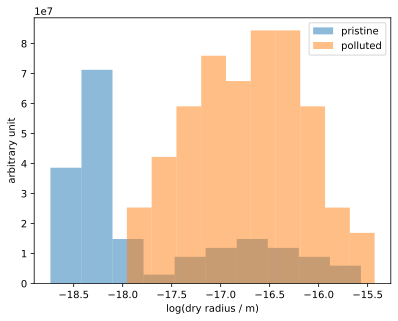

In [9]:
run(n_sd=2**6, plot_spectrum=True)

In [10]:
all_solutions = defaultdict(dict)
all_times = defaultdict(dict)

velocities_multiplier = (
    1,
    0.5,
    0.002,
)
non_adaptive_substeps = 50
rtols = namedtuple("RT", ("x", "rh", "rh_eq", "thd", "name"))(
    x=1e-8, rh=np.nan, thd=1e-7, rh_eq=1e-6, name="thd"
)
for w_val in velocities_multiplier:
    solutions_w, times_w = run(N_SD, rtol=rtols, w_multiplier=w_val, lsoda_eps=1e-4, non_adaptive_substeps=non_adaptive_substeps)

    for k, solution in solutions_w.items():
        all_solutions[k][w_val] = solution
        all_times[k][w_val] = times_w[k]

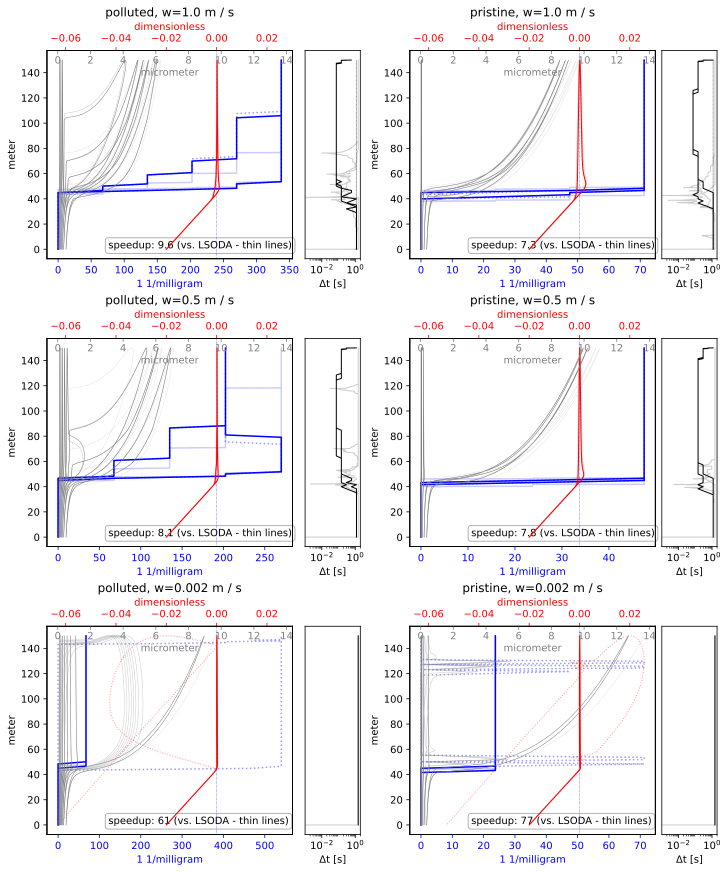

In [11]:
row_params = velocities_multiplier
columns = ["polluted", "pristine"]
methods_params = {"adaptive": {"alpha": 1, "linestyle": '-',}, "LSODA": {"alpha": 0.2, "linestyle": '-',}, "non-adaptive": {"alpha": 0.4, "linestyle": ':',}}
nrows = len(row_params)
ncols = len(columns)*2
fig = pyplot.figure(figsize=(10, 4 * nrows), constrained_layout=True)
gs = GridSpec(nrows=nrows, ncols=ncols, width_ratios=[4, 0.9, 4, 0.9], figure=fig)
axs = np.empty((nrows, 4), dtype=object)
for i in range(nrows):
    for j in range(ncols):
        axs[i, j] = fig.add_subplot(
            gs[i, j], sharey=axs[0, 0] if (i > 0 or j > 0) else None
        )

twin_prev = None
d_color, s_color, r_color = "blue", "red", "grey"
for i, param in enumerate(row_params):
    for j, aerosol_type in enumerate(columns):
        ax = axs[i, 2 * j]
        ax_s = ax.twiny()
        ax_r = ax.twiny()
        ax_dt = axs[i, 2 * j + 1]
        ax_dt.yaxis.set_visible(False)
        if twin_prev:
            ax_s.sharex(twin_prev[0])
            ax_r.sharex(twin_prev[1])
            ax_dt.sharex(twin_prev[2])
        twin_prev = ax_s, ax_r, ax_dt

        with DimensionalAnalysis():
            consts, si = constants(
                n_sd=N_SD,
                aerosol=aerosol_type,
                kappa=commons["kappa"],
                total_water_mixing_ratio=commons["total_water_mixing_ratio"],
                t_max_s=commons["t_max_s"],
                w_multiplier=param,
            )
            si.setup_matplotlib()
            ax.set_title(f"{aerosol_type}, w={consts.w_mean:~}")
            ax.xaxis.set_units(1 / si.mg)
            ax_s.axvline(0, linestyle=":", color="blue", linewidth=0.5, label="RH=100%")
            ax_r.xaxis.set_units(si.um)
            ax_dt.set_xscale("log")

            for method, params in methods_params.items():
                solution = all_solutions[aerosol_type][param][method]

                time = solution.t * si.s
                pressure = solution.y[consts.ix.pd] * si.Pa
                temperature = solution.y[consts.ix.T] * si.K
                r_wet = formulae.rw(consts, solution.y[consts.ix.x])
                mass_liquid = formulae.ml(consts, rw=r_wet, xi=consts.xi)

                supersaturation = formulae.RH(
                    consts,
                    ml=mass_liquid,
                    rho_vs=formulae.rhov(consts, pv=formulae.pvs(consts, temperature), T=temperature),
                    rhod=formulae.rhod(consts, pd=pressure, T=temperature),
                ) - 1
                ax_s.plot(
                    supersaturation,
                    formulae.z(consts, time),
                    color="red",
                    linewidth=1,
                    label="supersaturation",
                    alpha=params["alpha"],
                    linestyle=params["linestyle"],
                )

                for idx in range(consts.ix.x.start, consts.ix.x.stop):
                    ax_r.plot(
                        r_wet[idx],
                        formulae.z(consts, time),
                        color="gray",
                        linewidth=0.5,
                        alpha=params["alpha"],
                    )
                n_activated = (
                    (r_wet > formulae.r_c(consts, consts.rd)[:, None]) * consts.xi[:, None]
                ).sum(axis=0)
                ax.plot(
                    n_activated / consts.m_d,
                    formulae.z(consts, time),
                    color="blue",
                    linewidth=1.5,
                    alpha=params["alpha"],
                    linestyle=params["linestyle"],
                )
                if method not in ("LSODA", "non-adaptive") :
                    dt_plot = solution.dt_adaptive
                else:
                    dt_plot = np.diff(time)
                z_mid = formulae.z(consts, time[:-1] + np.diff(time))
                ax_dt.plot(
                    dt_plot, z_mid, color="k", alpha=params["alpha"], linewidth=1, linestyle=params["linestyle"],
                )
                ax_dt.set_xticks((1, 0.01))
                ax_dt.set_xlim(0.001, 2)
                ax_dt.set_xlabel("Δt [s]")

            speedup = (
                all_times[aerosol_type][param]["LSODA"]
                / all_times[aerosol_type][param]["adaptive"]
            )
            ax.annotate(
                f"speedup: {speedup:.2g} (vs. LSODA - thin lines)",
                xy=(0.25, 0.05),
                xycoords="axes fraction",
                ha="left",
                bbox={"boxstyle": "round,pad=0.3", "fc": "white", "ec": ".7", "lw": 1},
            )
        ax.tick_params(axis="x", colors=d_color)
        ax.xaxis.label.set_color(d_color)
        ax_s.tick_params(axis="x", colors=s_color, labelcolor=s_color)
        ax_s.xaxis.label.set_color(s_color)
        ax_r.tick_params(
            axis="x", direction="in", colors=r_color, labelcolor=r_color, pad=-15
        )
        ax_r.xaxis.label.set_color(r_color)
        ax_r.xaxis.set_label_coords(0.5, 0.88)

show_plot("plots")

## Speedup
### Speedup between methods

adaptive vs LSODA
adaptive vs non-adaptive

In [12]:
speedup_w = {
    a_t: {
        "LSODA-vs-adaptive": [t[w]["LSODA"] / t[w]["adaptive"] for w in t],
        "non-vs-adaptive": [t[w]["non-adaptive"] / t[w]["adaptive"] for w in t]}
    for a_t, t in all_times.items()
}

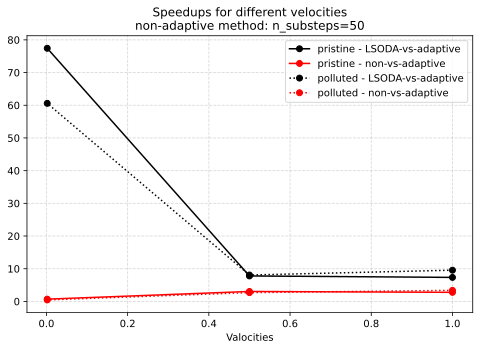

In [13]:
pyplot.figure(figsize=(8, 5))
x = velocities_multiplier
color_params = {"LSODA-vs-adaptive": 'k', "non-vs-adaptive": 'r'}
style_params = {"pristine": '-', "polluted": ':'}
for aerosol_type, item in speedup_w.items():
    for comparison_key, values in item.items(): 
        pyplot.plot(x, values, marker="o", label=f"{aerosol_type} - {comparison_key}", color=color_params[comparison_key], linestyle=style_params[aerosol_type])
pyplot.title("Speedups for different velocities\nnon-adaptive method: n_substeps=50")
pyplot.xlabel("Valocities")
pyplot.legend()
pyplot.grid(True, which="both", linestyle="--", alpha=0.5)
show_plot("speedup_w")

time vs. number of droplets scaling plot

In [14]:
all_times_nds = defaultdict(dict)
nds = (2**2, 2**4, 2**6, 2**10)

for n_droplets in nds:
    _, time_dict = run(n_sd=n_droplets, w_multiplier=1, lsoda_eps=1e-4, rtol=rtols)
    for k, t in time_dict.items():
        all_times_nds[k][n_droplets] = t

In [15]:
speedup = {
    k: {n: t[n]["LSODA"] / t[n]["adaptive"] for n in t}
    for k, t in all_times_nds.items()
}

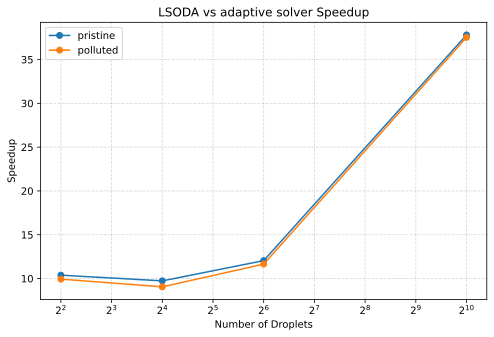

In [16]:
pyplot.figure(figsize=(8, 5))

for label, values in speedup.items():
    x = sorted(values.keys())
    y = [values[k] for k in x]
    pyplot.plot(x, y, marker="o", label=label)

pyplot.xscale("log", base=2)
pyplot.xlabel("Number of Droplets")
pyplot.ylabel("Speedup")
pyplot.title("LSODA vs adaptive solver Speedup")
pyplot.legend()
pyplot.grid(True, which="both", linestyle="--", alpha=0.5)
show_plot("speedup")

TODO:
- adaptive ODE solver
- plots for different tolerances
- time vs. number of droplets scaling plot
- tolerances in SciPy solver
- comparison for different size attributes (time efficiency, accuracy)
- Numba threading
- thermo triplet arrays!
- switch thd to rh in adapt substeps
- toms/SciPy
- codecov

IDEAS:
- Jacobian
- isotopes